# MovieLens data set

In [1]:
import numpy as np
import sklearn as sk
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


## Explore the data

data set downloaded from https://grouplens.org/datasets/movielens/

ml-latest-smallest.zip

In [2]:
links = pd.read_csv("~/Downloads/ml-latest-small/links.csv")
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [3]:
movies = pd.read_csv("~/Downloads/ml-latest-small/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = pd.read_csv("~/Downloads/ml-latest-small/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
tags = pd.read_csv("~/Downloads/ml-latest-small/tags.csv")
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [6]:
num_users=len(ratings["userId"].unique())
num_movies=len(ratings["movieId"].unique())
num_users,num_movies

(610, 9724)

In [7]:
# let's count ratings per user
print("total number of ratings: ",len(ratings))
counts=ratings.groupby('userId')['rating'].count()
print("average number of ratings per user: {:2.1f}".format(counts.mean()))
print("missing ratings: {:2.1f}%".format((1-len(ratings)/num_users/num_movies)*100))

total number of ratings:  100836
average number of ratings per user: 165.3
missing ratings: 98.3%


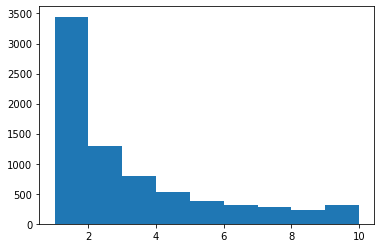

In [8]:
counts=ratings.groupby('movieId')['rating'].count()
plt.hist(counts,bins=[1,2,3,4,5,6,7,8,9,10])
plt.show()

## test set, training set

In [9]:
users=ratings['userId'].unique()
movies=ratings['movieId'].unique()

In [10]:
# let's shuffle the DataFrame
ratings=shuffle(ratings)
ratings.reset_index(inplace=True,drop=True)
ratings.head()

,userId,movieId,rating,timestamp
0,357,19,2.0,1348612202
1,477,53953,4.0,1200944081
2,573,3897,3.5,1187044921
3,426,3751,4.0,1451081732
4,292,2761,5.0,1015374932


In [11]:
train_size=80000
ratings_train=ratings.loc[:train_size-1,:]
y_train=ratings_train['rating']
ratings_test=ratings.loc[train_size:,:]
y_test=ratings_test['rating']

In [12]:
movies_in_train=ratings_train['movieId'].unique()
not_seen_before=[]
for movie in ratings_test['movieId'].unique():
    if not movie in movies_in_train:
        not_seen_before.append(movie)
print("{} movies in test set that did not appear in training set".format(len(not_seen_before)))

760 movies in test set that did not appear in training set


In [13]:
users_in_train=ratings_train['userId'].unique()
users_not_seen_before=[]
for user in ratings_test['userId'].unique():
    if not user in users_in_train:
        users_not_seen_before.append(user)
print("{} users in test set that did not appear in training set".format(len(users_not_seen_before)))

0 users in test set that did not appear in training set


-> we have a cold start problem for the movies. What should we predict for movies for which we do not have any ratings?

## baselines: fill in mean ratings

To get a baseline, let's simply predict mean values. Obviously, any useful recommender system should beat this baseline.

In [14]:
mean_rating=y_train.mean()
err=mean_squared_error(y_test,np.ones(len(y_test))*mean_rating)
print("mean rating over all movies: {:1.2f}".format(mean_rating))
print("MSE when returning overall mean: {:1.2f}".format(err))

mean rating over all movies: 3.50
MSE when returning overall mean: 1.09


In [15]:
movie_rating_mean=ratings_train.groupby('movieId')['rating'].mean()

def movie_mean(movie):
    try:
        result=movie_rating_mean[movie]
    except KeyError:   ## haven't seen this movie during training
        result=mean_rating
    return result

# another baseline: fill in movie means
movie_means=np.array([movie_mean(movie) for movie in ratings_test['movieId']])
err=mean_squared_error(y_test,movie_means)
print("MSE when returning movie means: {:1.2f}".format(err))

MSE when returning movie means: 0.96


In [16]:
user_rating_mean=ratings_train.groupby('userId')['rating'].mean()

def user_mean(user):
    return user_rating_mean[user]

user_means=np.array([user_mean(user) for user in ratings_test['userId']])
err=mean_squared_error(y_test,user_means)
print("MSE when returning user means: {:1.2f}".format(err))

MSE when returning user means: 0.88


## Model user enthusiasm and film popularity

In [17]:
# For linear regression we need to put enthusiasm[user] and popularity[film] 
# into one vector. Two dictionaries, user_map and movie_map, tell us at what 
# position we find an entry corresponding to a specific user or film
all_users=ratings_train['userId'].unique()
user_map=dict(zip(all_users,range(len(all_users))))

all_movies=ratings_train['movieId'].unique()
movie_map=dict(zip(all_movies,range(len(all_users),len(all_users)+len(all_movies))))

# List the order we encounter specific users/films when we go through the training set.
# Order points to entries under user_map / movie_map.
user_order=np.array([user_map[row['userId']] for index, row in ratings_train.iterrows()])
movie_order=np.array([movie_map[row['movieId']] for index, row in ratings_train.iterrows()])

In [18]:
# Let's build the "data" matrix X in order to solve the linear regression problem
# min_w || R-X.transpose * w||
# Note: X will be huge.
num_users=len(all_users)
num_movies=len(all_movies)
X=np.zeros((len(y_train),num_users+num_movies))
for i,(user,movie) in enumerate(zip(user_order,movie_order)):
    X[i,user]=1
    X[i,movie]=1

In [19]:
from sklearn.linear_model import SGDRegressor
import scipy
reg=SGDRegressor(fit_intercept=False)
# because X is huge, we use a sparse matrix -- support for sparse matrices implemented in scipy
reg.fit(scipy.sparse.csr_matrix(X),y_train-mean_rating)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=False, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [20]:
# Prediction code should really be assembled into a class

enthusiasm=reg.coef_[:len(all_users)]
popularity=reg.coef_[len(all_users):]

def single_simple_predict(user,movie):
    try:
        result=mean_rating+enthusiasm[user_map[user]]+popularity[movie_map[movie]-len(all_users)]
    except KeyError:  # catch movies/users that did not appear in training set
        result=mean_rating  # fallback
    return result

def simple_predict(user_movie):
    return np.array([single_simple_predict(row['userId'],row['movieId']) for index,row in user_movie.iterrows()])

In [21]:
enthusiasm.mean(),popularity.mean()

(0.026719359550698887, 0.0018182518212769183)

In [22]:
err=mean_squared_error(y_test,simple_predict(ratings_test))
print("MSE under simple user enthusiasm / film popularity: {:1.2f}".format(err))

MSE under simple user enthusiasm / film popularity: 0.85


## nearest neighbour

Warning: code below is rather hacky

In [23]:
# calculate correlation coefficients with in-built pandas methods
# unfortunately, I need generate a rather large ratings matrix
# function DataFrame.corr ignores NaN values, which is good
ratings_matrix=ratings_train.pivot(index='movieId',columns='userId',values='rating')
corr_matrix=ratings_matrix.corr()
corr_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,NaN,NaN,0.381328,0.185030,-0.134430,-0.028603,0.534522,0.918559,-1.00000,...,-0.077850,0.000000,0.090235,-0.424264,-0.342777,0.005219,0.099487,0.273125,0.000000,-0.196433
2,NaN,1.0,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,1.00000,...,-0.289344,NaN,-1.000000,NaN,NaN,0.583333,NaN,-0.125000,NaN,0.612439
3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.452267,NaN,NaN,-0.662266,NaN,NaN,NaN,0.963436
4,0.381328,NaN,NaN,1.000000,-0.793884,0.174213,0.325036,0.327327,NaN,0.82734,...,-0.216506,0.492716,0.072037,-0.790569,0.338591,0.108229,0.169076,-0.070998,1.000000,0.126919
5,0.185030,NaN,NaN,-0.793884,1.000000,-0.185431,0.031054,0.102598,NaN,NaN,...,0.000000,0.045521,0.377297,0.135333,-0.506024,0.279654,0.193649,-0.047758,0.179605,0.042126


In [28]:
fallback_count=0
peer_group_size=5

def predict_for_user(user,movie):
    global fallback_count
    # filter out all users that actually rated this movie
    rating_users=ratings_train.loc[ratings_train['movieId']==movie,'userId']
    # among the rating users, pick those five with largest correlation to current user
    most_correlated=corr_matrix.loc[user,rating_users].nlargest(n=peer_group_size)
    most_correlated=most_correlated[most_correlated>0]  # restrict to positive correlation
    rating_neighbours=ratings_train[(ratings_train['userId'].isin(most_correlated.index)) & (ratings_train['movieId']==movie)]
    # we simply pick the mean among the neighbours
    pred_rating=rating_neighbours['rating'].mean()
    if np.isnan(pred_rating):     # if there are no neighbours, mean will be NaN
        fallback_count+=1
        return movie_mean(movie)  # fallback
    return pred_rating

def predict(user_movie):
    global fallback_count
    fallback_count=0
    return np.array([predict_for_user(row['userId'],row['movieId']) for index,row in user_movie.iterrows()])

In [25]:
predict(ratings_test[:5])

array([2.8       , 4.2       , 3.4       , 3.3       , 1.83333333])

In [29]:
pred_ratings=predict(ratings_test)
err=mean_squared_error(pred_ratings,y_test)
print("MSE under nearest neighbour: {:1.2f}".format(err))
print("fallback / total: {} / {}".format(fallback_count,len(y_test)))

MSE under nearest neighbour: 1.04
fallback / total: 962 / 20836
